## Example 3: Optimizing the efficiency
The luminous efficiency is defined by the following integral:
\begin{equation}
\eta_{lum} = \frac{\int_0^{\infty} BB(\lambda, T) \epsilon(\lambda) v(\lambda) d\lambda}{\int_0^{\infty} BB(\lambda, T) \epsilon(\lambda)d\lambda},
\end{equation}
where $BB(\lambda, T)$ is Planck's blackbody law, $\epsilon(\lambda)$ is the emissivity function 
of the structure, and $v(\lambda)$ is the photopic luminosity function that characterizes the color sensisitivity of the human eye.  Only the $\epsilon(\lambda)$ function depends on the structure itself.
As a consequence, we can imagine that by changing the thickness of a giving coating layer on 
a tungsten slab (as we saw in Example 2) can change the value of $\eta_{lum}$, and some coating thickness
will lead to a maximum value of $\eta_{lum}$.  In the case where $\eta_{lum}$ has been maximized through 
the thickness of a coating layer $t_{coat}$, we can say that the derivative of $\eta_{lum}$ with respect
to the coating thickness is zero:
following condition:
\begin{equation} 
\frac{d}{d t_{coat}} \eta_{lum} = \frac{d}{d t_{coat}} \left( \frac{\int_0^{\infty} BB(\lambda, T) \epsilon(\lambda) v(\lambda) d\lambda}{\int_0^{\infty} BB(\lambda, T) \epsilon(\lambda)d\lambda} \right) = 0.
\end{equation}

The derivative of the luminous efficiency involves differentiating both the numerator and the denominator:
\begin{equation} 
\frac{d}{d t_{coat}} \eta_{lum} = \frac{D(\lambda, T) N'(\lambda,T) - N(\lambda, T) D'(\lambda,T)}{D(\lambda, T)^2}
\end{equation}
where 
\begin{equation}
N'(\lambda, T) = \int_0^{\infty} BB(\lambda, T) \frac{d}{dt_{coat}}\epsilon(\lambda) v(\lambda) d\lambda
\end{equation}
and 
\begin{equation}
D'(\lambda, T) = \int_0^{\infty} BB(\lambda, T) \frac{d}{dt_{coat}}\epsilon(\lambda) d\lambda.
\end{equation}
The equation above suggests that to get the derivative of $\eta_{lum}$, we need to evaluate terms in the standard luminous efficiency expression using the derivative of the emissivity, $\frac{d}{d t_{coat}} \epsilon(\lambda)$ in addition to $\epsilon(\lambda)$ itself. 
We can get $\frac{d}{d t_{coat}} \epsilon(\lambda)$ in several ways; the conceptually simplest approach is to approximate it with $finite$ $differences$:
\begin{equation}
\frac{d}{d t_{coat}} \epsilon(\lambda; t_{coat}) \approx \frac{ \epsilon(\lambda; t_{coat}+dt) - \epsilon(\lambda; t_{coat}-dt)}{2dt}
\end{equation}
where we use $\epsilon(\lambda; t_{coat})$ to denote the emissivity function evaluated for a structure with 
coating thickness $t_{coat}$ and $dt$ is a small change in thickness.

One way to compute such finite differences is to create several instances of a coated structure we wish to investigate that are different by small changes in the coating thickness.  

In [45]:
from wptherml.wpml import multilayer
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

### dictionary that stores basic properties 
### of the multilayer structure you want to simulate
structure = {
        ### computation mode - inline means the structure and calculation
        ### type will be determined from the values of this dictionary
        'mode': 'Inline',
        ### temperature of the structure - relevant for all thermal applications
        ### value is stored in attribute self.T
        'Temperature': 2400,
        ### actual materials the structure is made from
        ### values are stored in the attribute self.n
        'Material_List' : ['Air', 'SiO2', 'TiO2', 'TiN', 'Air'], 
        ### thickness of each layer... terminal layers must be set to zero
        ### values are stored in attribute self.d 6.00600166e-10 2.68115351e-08
        'Thickness_List': [0, 6.006e-10, 2.65e-8, 900e-9, 0],
         ### range of wavelengths optical properties will be calculated for
         ### values are stored in the array self.lam
        'Lambda_List': [300e-9, 4000e-9, 1000],
         ### The folloing entry will tell the computer to use the lightbulb functions to
         ### compute properties needed to characterize an incandescent source
         'LIGHTBULB': 1
     
        }

### create the instance called coated_w_slab that is the "base" structure we 
### wish to evaluate
coated_w_slab = multilayer(structure)
current_efficiency = coated_w_slab.luminous_efficiency_val
print(current_efficiency)


0.03469078689290609


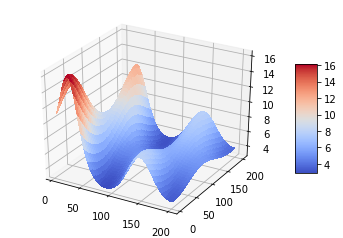

In [32]:
### method to compute reflectivity, transmissivity, and absorptivity vs angle at a specified
### wavelength... results are stored in the attributes
### self.r_vs_theta, self.t_vs_theta, and self.eps_vs_theta... array of angles is self.theta_array

fig = plt.figure()
ax = fig.gca(projection='3d')

N_points = 40
eta_vs_d = np.zeros((N_points,N_points))
d1_array = np.linspace(5e-9,200e-9,N_points)
d2_array = np.linspace(5e-9,200e-9,N_points)
delta = 0.1e-9
i = 0
for dsio2 in d1_array:
    j = 0
    for dtio2 in d2_array:
        coated_w_slab.d[1] = dsio2
        coated_w_slab.d[2] = dtio2
        coated_w_slab.fresnel()
        coated_w_slab.thermal_emission()
        coated_w_slab.luminous_efficiency()
        eta_vs_d[i][j] = coated_w_slab.luminous_efficiency_val
        j = j + 1
    i = i + 1

X, Y = np.meshgrid(d1_array, d2_array)
surf = ax.plot_surface(1e9*X, 1e9*Y, 100*eta_vs_d, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

We can use a built-in capability of the scipy library to find the optimium value of the coating
thickness in a given range.  In particular, we can use what is called a quasi-Newtom method, the BFGS method in particular, to optimize the thickness: https://en.wikipedia.org/wiki/Quasi-Newton_method
The scipy function $minimize$ can be called to perform such an optimization to minimize a function given 
the ability to evaluate that function at various points and the ability to evaluate its derivative.  Note that if we just define a python function that returns $1-\eta_{lum}$ and a python function that returns the derivative of $1-\eta_{lum}$, then scipy's $minimize$ can find the minimum of $1-\eta_{lum}$, which is the same as the maximum of $\eta_{lum}$ itself.

In [46]:
### import minimize function from scipy
from scipy.optimize import minimize

In [47]:
### define a function that returns 1-eta_lum for the simple coated w structure
def objective(x):
    val1 = x[0]
    val2 = x[1]
    coated_w_slab.d[1] = val1
    coated_w_slab.d[2] = val2
    coated_w_slab.fresnel()
    coated_w_slab.thermal_emission()
    coated_w_slab.luminous_efficiency()
    return (1 - coated_w_slab.luminous_efficiency_val)
    #return (val-10)**2


def objective_der(x):
    val1 = x[0]
    grad = 2*val - 20
    delta = 0.05e-9
    coated_w_slab.d[1] = val
    #coated_w_slab_f.d[1] = val + delta
    #coated_w_slab_b.d[1] = val - delta
    #coated_w_slab.fresnel()
    #coated_w_slab.Fresnel_Prime()
    #coated_w_slab.ThermalEmission()
    #coated_w_slab.TE_prime = coated_w_slab.BBs * coated_w_slab.Emissivity_prime
    #coated_w_slab.luminous_efficiency_prime()
    #return coated_w_slab.eta_lum_prime 
    return grad


    
    

In [48]:
x0 = np.array([50e-9, 50e-9])
print(x0)
print(objective(x0))
#print(objective_der(x0))
#res = minimize(objective, x0, method='BFGS', jac=objective_der, options={'gtol': 1e0, 'disp': True})
res = minimize(objective, x0, method='nelder-mead', options={'xtol': 1e-10, 'disp': True})
print(res.x)
print(objective(res.x))
#print(objective_der(res.x))

[5.e-08 5.e-08]
0.9848285538324814
Optimization terminated successfully.
         Current function value: 0.965223
         Iterations: 41
         Function evaluations: 79
[1.31257713e-09 2.47616334e-08]
0.9652228535285464


In [ ]:
print(objective_der(res.x))